In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Preparing the data

In [2]:
data = pd.read_csv("./data/Animated_Tv_Series.csv", encoding = "ISO-8859-1")

In [3]:
data

,Id,Title,Episodes,Year,Original channel,American company,Note,Technique,IMDb,Google users
0,1,2 Stupid Dogs,26.0,1993-1995,TBS,Hanna-Barbera,NaN,Traditional,7.2,91%
1,2,3-2-1 Penguins!,27.0,2000-2008,Direct to video,Big Idea Productions,NaN,CGI,6.5,91%
2,3,3-South,13.0,2002-2003,MTV,Warner Bros. AnimationMTV Animation,NaN,Traditional,8.0,87%
3,4,3Below: Tales of Arcadia,28.0,2018-2019,Netflix,DreamWorks Animation Television,NaN,CGI,7.6,77%
4,5,3rd & Bird,51.0,2008-2010,Playhouse Disney,Little Airplane Productions,British co-production,Flash,7.8,92%
...,...,...,...,...,...,...,...,...,...,...
1811,1812,The ZhuZhus,26.0,2016-2017,Disney Channel,Cepia LLC,Canadian co-production,Flash,5.5,72%
1812,1813,Zoboomafoo,65.0,1999-2001,PBS Kids,Maryland Public Television,Canadian co-production,Stop-motion/Live-action,7.6,95%
1813,1814,Zombie College,12.0,2000-2001,NaN,icebox.com,NaN,Flash,6.8,62%
1814,1815,Zootopia+,6.0,2022,Disney+,Walt Disney Animation Studios,NaN,CGI,6.8,74%


In [4]:
#Count NaN in more relevent columns i.e. IMDb and Google users
print(len(data[data["IMDb"].isnull()]))
print(len(data[data["Google users"].isnull()]))

4
4


In [5]:
# As the number is low, removing them won't have significant on our analysis
data = data[-data["IMDb"].isnull()]
data = data[-data["Google users"].isnull()]
print(len(data))

1810


In [136]:
def change_percent_to_float(percent):
    percent = percent[:-1]
    return int(percent)/10

def to_lower(text):
    return text.lower()

In [7]:
#Making Google rating have the same scale with IMDb score
data["Google users"] = data["Google users"].apply(change_percent_to_float)

In [137]:
data["Technique"] = data["Technique"].apply(to_lower)

# Rating Analysis

In [8]:
from scipy.stats import pearsonr, skew

In [9]:
corr, _ = pearsonr(data["Google users"], data["IMDb"])
print(corr)

0.5282464829191829


Text(0, 0.5, 'freq')

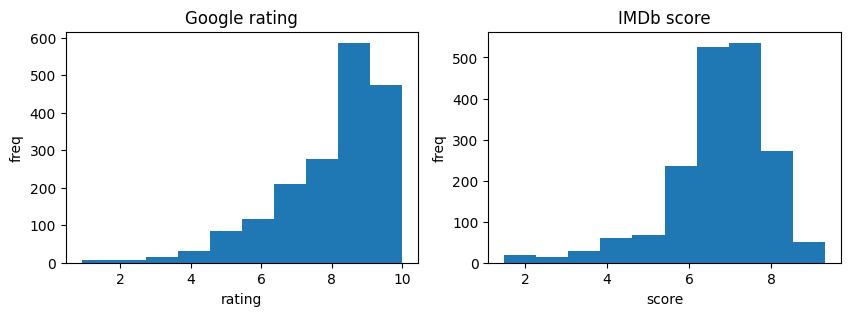

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
ax1.hist(data["Google users"])
ax1.set_title("Google rating")
ax1.set_xlabel("rating")
ax1.set_ylabel("freq")
ax2.hist(data["IMDb"])
ax2.set_title("IMDb score")
ax2.set_xlabel("score")
ax2.set_ylabel("freq")

In [11]:
print(skew(data["Google users"]))
print(skew( data["IMDb"]))

-1.3981104723402056
-1.2076124070765104


From our rating analysis, we found that even though both Google rating and IMDb score are relatively correlated and have rather similar distribution, Google rating is more skewing toward the higher score. In conclusion, IMDb users base are holding back more when rating an animated TV show/movie.

# Clustering them based on rating

In [48]:
rating = data[["Title","Google users","IMDb"]]

In [49]:
from sklearn.cluster import KMeans

Text(0, 0.5, 'IMDb score')

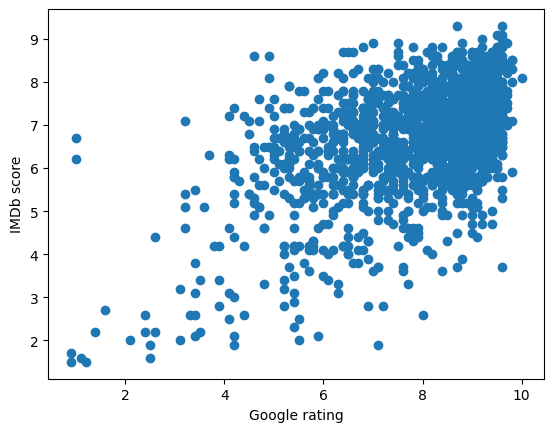

In [50]:
plt.scatter(rating["Google users"],rating["IMDb"])
plt.xlabel("Google rating")
plt.ylabel("IMDb score")

In [51]:
tmp = []
for i in range(1,10):
    km = KMeans(n_clusters=i)
    km.fit(rating[["Google users","IMDb"]])
    tmp.append(km.inertia_)

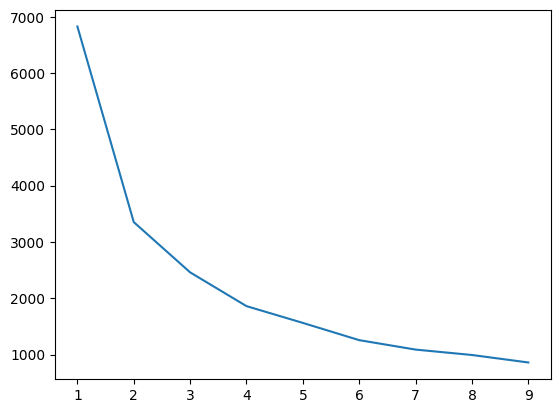

In [52]:
plt.plot(np.arange(1,10,1),tmp)

In [68]:
km = KMeans(n_clusters=4)
km.fit(rating[["Google users","IMDb"]])

KMeans(n_clusters=4)

In [69]:
labels = km.predict(rating[["Google users","IMDb"]])

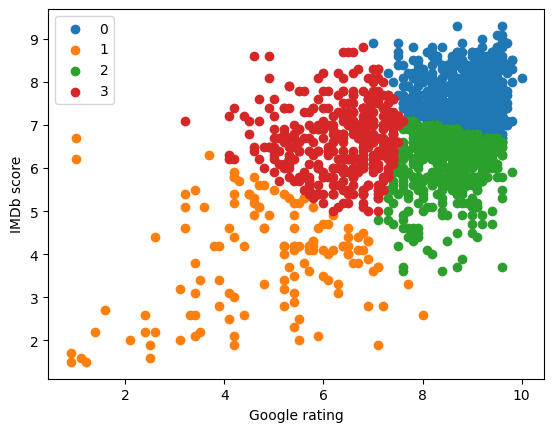

In [70]:
plt.scatter(rating["Google users"][labels == 0],rating["IMDb"][labels == 0],label = "0")
plt.scatter(rating["Google users"][labels == 1],rating["IMDb"][labels == 1],label = "1")
plt.scatter(rating["Google users"][labels == 2],rating["IMDb"][labels == 2],label = "2")
plt.scatter(rating["Google users"][labels == 3],rating["IMDb"][labels == 3],label = "3")
plt.xlabel("Google rating")
plt.ylabel("IMDb score")
plt.legend()

In [107]:
data["class"] = labels

In [108]:
# This Cell might have to change to suit new model label.
def map_class(label):
    if label == 0:
        return "A"
    elif label == 1:
        return "C"
    elif label == 2:
        return "B"
    else:
        return "B"

In [109]:
data["class"] = data["class"].apply(map_class)

From the elbow graph, we can see that the optimal number of clusters is somewhere between 3-4 clusters (I pick 4 in this case as it is a bit easier to explain each cluster). Group 0 are shows/movies that get high Google rating and IMDb score. Group 1 are shows/movies that get low Google rating and IMDb score. Group 2,3 are shows/movies that get high Google rating but low IMDb score and vice versa. As a result, we can put every shows/movies into tier A,B,C based on this 4 clusters (0 to A,1 to B, 2 to C and 3 to B). 

# Some Interesting Questions

## Given this dataset, if I want to make an animated TV series, which company should I pick, which channel I should publish it and which technique I should use toget the best result rating-wise???

There are 2 approaches we can take with this question. The first one is based on the tier we establish from clustering previously. The second approach is based on raw Google rating and IMDb score.

Since number of series each company produces aren't the same. Direct counting doesn't sound resonable anymore as we might miss a high quality company that not produces many series(same argument applies to technique and publication channel too).

### Approach 1

As we explain why counting how many A-tier series each company produced and compare it directly is a wise option. We will use the probability of series produced by that company rank in A-tier as a comparator instead. Also filter out any company that produces low number of series as that might only be a fluke.

In [138]:
companies = data["American company"].unique()

In [139]:
max_prob = 0
for company in companies:
    if isinstance(company,float):
        continue
    tmp = data[data["American company"] == company]
    if len(tmp) < 5:
        continue
    prob = len(tmp[tmp['class'] == 'A'])/len(tmp)
    if max_prob < prob:
        max_prob = prob
        best_company = company
print(best_company, max_prob)

Walt Disney Productions 1.0


In [140]:
publishers = data["Original channel"].unique()

In [141]:
max_prob = 0
for publisher in publishers:
    if isinstance(publisher,float):
        continue
    tmp = data[data["Original channel"] == publisher]
    if len(tmp) < 5:
        continue
    prob = len(tmp[tmp['class'] == 'A'])/len(tmp)
    if max_prob < prob:
        max_prob = prob
        best_publisher = publisher
print(best_publisher, max_prob)

Noggin 0.8333333333333334


In [142]:
techniques = data["Technique"].unique()

In [143]:
max_prob = 0
for technique in techniques:
    if isinstance(technique,float):
        continue
    tmp = data[data["Technique"] == technique]
    if len(tmp) < 5:
        continue
    prob = len(tmp[tmp['class'] == 'A'])/len(tmp)
    if max_prob < prob:
        max_prob = prob
        best_technique = technique
print(best_technique, max_prob)

traditional/live-action 0.7727272727272727


From approach 1, we can conclude that an animated TV series that produces by Walt Disney Productions,uses Traditional/Live-action technique and publishes through Noggin will produce the best result.

### Approach 2

For this approach, we will try to answer this question through raw Google rating and IMDb score. To simplify a little bit, the score we will use in this approach is average between Google rating and IMDb score. We can compare likelihood of getting good series by compare skewness of score distribution. The more its skews to the right, the more likelihood of that company/publisher/technique will get high score.

In [144]:
data["avg_score"] = (data['Google users'] + data['IMDb'])/2

In [145]:
min_skewness = 0
for company in companies:
    if isinstance(company,float):
        continue
    tmp = data[data["American company"] == company]
    if len(tmp) < 5:
        continue
    skewness = skew(tmp["avg_score"])
    if min_skewness > skewness:
        min_skewness = skewness
        best_company = company
print(best_company, min_skewness)

Filmation -2.8355570307017333


In [146]:
min_skewness = 0
for publisher in publishers:
    if isinstance(publisher,float):
        continue
    tmp = data[data["Original channel"] == publisher]
    if len(tmp) < 5:
        continue
    skewness = skew(tmp["avg_score"])
    if min_skewness > skewness:
        min_skewness = skewness
        best_publisher = publisher
print(best_publisher, min_skewness)

CBS -2.601223685943592


In [147]:
min_skewness = 0
for technique in techniques:
    if isinstance(technique,float):
        continue
    tmp = data[data["Technique"] == technique]
    if len(tmp) < 5:
        continue
    skewness = skew(tmp["avg_score"])
    if min_skewness > skewness:
        min_skewness = skewness
        best_technique = technique
print(best_technique, min_skewness)

traditional/live-action -3.23075040578544


From approach 2, we can conclude that an animated TV series that produces by Filmation, uses Traditional/Live-action technique and publishes through CBS will produce the best result.